# Multivariate Input - Multivariate Output -Single-Step

In [32]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
def multivariate_multivariate_single_step(sequence,window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix,:]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 10
window_size = 4
n_step = 1
learning_rate = 0.01
#seed
torch.manual_seed(123)

## Synthetic Data

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

<AxesSubplot:>

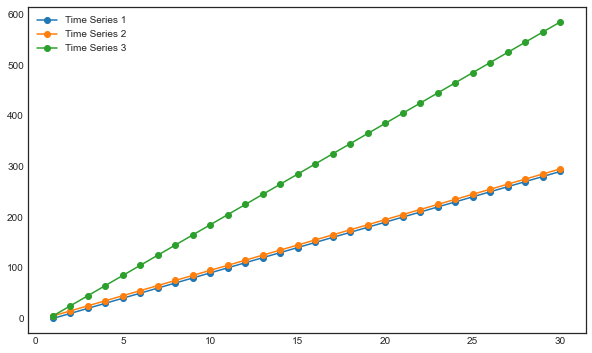

In [51]:
dataset_plot=pd.DataFrame(dataset,columns=["Time Series 1","Time Series 2","Time Series 3"],index=range(1,len(dataset)+1))
dataset_plot.plot(marker='o', figsize=(10,6))

In [7]:
split_data = round(len(dataset)*split_ratio)
split_data

21

In [8]:
#split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Normalization

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

In [10]:
#transform after scaling
train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
print("test_data_normalized"+str(train_data_normalized.shape))

test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_normalized"+str(test_data_normalized.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


## Data Seqeuncing

In [11]:
trainX ,trainY =  multivariate_multivariate_single_step(train_data_normalized,window_size)
testX , testY = multivariate_multivariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(17, 4, 3) trainY shape:(17, 3)

testX shape:(5, 4, 3) testY shape:(5, 3)


## Data Transform

In [12]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [13]:
# 3D Data Preparation
trainX = torch.reshape(trainX,(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
testX = torch.reshape(testX,(testX.shape[0],trainX.shape[1],trainX.shape[2]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [14]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

## Vanila LSTM

In [15]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # out.size() --> 100, 28, 100
            # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
            out = self.fc(out[:, -1, :])
            # out.size() --> 100, 10
            return out

## Bidirectional LSTM


In [16]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

## Model Deployment

In [17]:
#Arguments for LSTM model
hidden_dim = 10
number_of_time_series = trainX.shape[2] 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

#Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=number_of_time_series, num_layers=num_layers)

#Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=number_of_time_series, num_layers=num_layers)

In [18]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [19]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
    #     Don't do this if you want your LSTM to be stateful
    #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _,(train_X,train_Y) in enumerate(train_iter):


            # Forward pass
            y_train_pred = model(train_X)

            #Reshape to perform MSE 
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train /len(train_X)
        train_loss[t] = epoch_loss_train





        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                #Reshape to perform MSE 
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test =running_loss_valid /len(test_X)

        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss

In [20]:
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

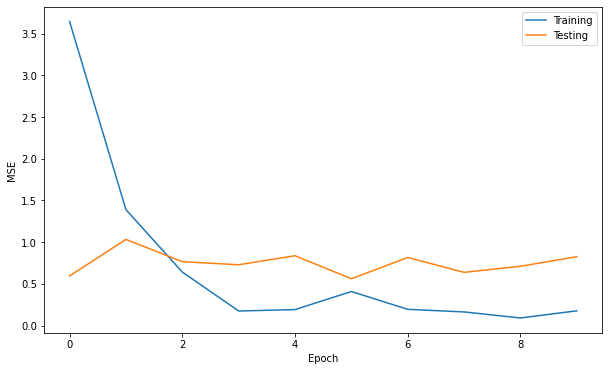

In [21]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Inference

In [23]:
# # make predictions
y_train_prediction = model(trainX)
y_test_prediction = model(testX)

# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [24]:
#Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [25]:
print("y-test\t\t\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

y-test				y-predict
[249.99998 255.      505.     ]		[341.08432 353.3141  464.2687 ]
[260. 265. 525.]		[347.44342 359.493   481.44507]
[270. 275. 545.]		[353.73215 365.53748 498.4935 ]
[280. 285. 565.]		[359.65338 371.28104 514.7712 ]
[290. 295. 585.]		[364.96072 376.5862  529.7165 ]


In [26]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

y_test_shape : (5, 3)
y_test_pred_shape : (5, 3)


In [27]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 31.01 RMSE
Test Score: 83.57 RMSE


In [92]:
# Function to plot multovariate data
def fittedvalues_and_forecast_plot(forecast, ax, color):
    forecast.plot(marker='^', ax=ax, color=color)

In [97]:
# Configure start data and end data to plot on data before sequencing 
start_data = split_data+window_size+1
end_data = start_data +len(y_test_prediction)

In [98]:
# Create DataFrame to plot graph
forecast=pd.DataFrame(y_test_prediction,columns=["Time Series 1","Time Series 2","Time Series 3"],
                      index=range(start_data,end_data))

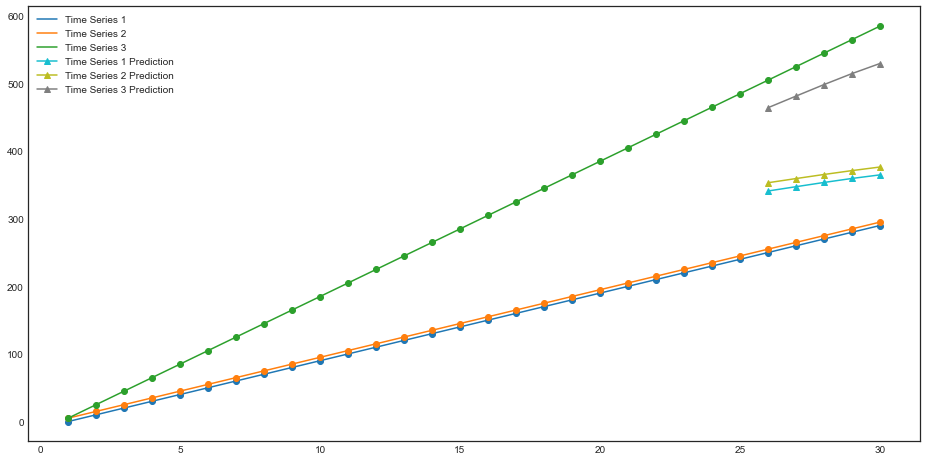

In [99]:
import matplotlib.lines as mlines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = dataset_plot.plot(marker='o', figsize=(16,8))
fittedvalues_and_forecast_plot(forecast.iloc[:,0], ax, colors[-1])
fittedvalues_and_forecast_plot(forecast.iloc[:,1], ax, colors[-2])
fittedvalues_and_forecast_plot(forecast.iloc[:,2], ax, colors[-3])

time_series1 = mlines.Line2D([], [], color=colors[0], label='Time Series 1')
time_series2 = mlines.Line2D([], [], color=colors[1], label='Time Series 2')
time_series3 = mlines.Line2D([], [], color=colors[2], label='Time Series 3')

ses1_line = mlines.Line2D([], [],marker='^', color=colors[-1], label='Time Series 1 Prediction')
ses2_line = mlines.Line2D([], [], marker='^',color=colors[-2], label='Time Series 2 Prediction')
ses3_line = mlines.Line2D([], [], marker='^',color=colors[-3], label='Time Series 3 Prediction')
plt.legend(handles=[time_series1,time_series2,time_series3,ses1_line, ses2_line, ses3_line])

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee